<a href="https://colab.research.google.com/github/c-a-asher/StyleGAN3-CLIP/blob/main/StyleGAN3_%2B_clip_for_texttoimage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NVidia StyleGAN3 Generator + OpenAI's CLIP nueral network Google Colab Notebook Implementation

First step: Ensure the notebook is being run with a GPU. Google Colab offers 5 different GPU setups (4 to free tiers) based upon current global usage, and are in order below from most powerful to least powerful. For Image and Video generation, it is recommended to at least have a T4 GPU, if not, generation will take awhile and you should either increase patience, or try again during a less activity-heightened time period.

V100 (Pro Users only)

P100 Best for free tier

T4 preferred

K80 much slower than T4

P4 Almost a waste of time to attempt generation


Runtime -> Change Runtime Type
Hardware Accelerator: GPU
Type: T4 or above, hopefully

Or can execute the code below to check type.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e3653bcb-e607-3a8f-c9f2-e7cc58f6485a)


The below code will clone the official StyleGAN3 and CLIP repositories from GitHub, and install the packages deemed necessary for code execution by NVIDIA and OpenAI for their products.

# Warning: This cell will take awhile to execute, do not interrupt!!

In [2]:
#install pytorch - a python library for deep learning
!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

#clone git repositories into colab notebook
!git clone https://github.com/NVlabs/stylegan3
!git clone https://github.com/openai/CLIP

#installs clip and einops tensor core operations
!pip install -e ./CLIP
!pip install einops ninja

#temporarily adds a PATH variable for the interpreter to use
import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan3')


#imports necessary packages already installed by default on colab into the project
import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
import unicodedata
import re
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files

#displays tensor device
device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 851.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 46.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.9.1+cu111 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but 

Using device: cuda:0


The following cell is optional - **You should run this cell if and only if you wish generated results to be automatically saved into your google drive.**

It is faster to get results placed directly inside your drive folder.

**Note: in order for this to work, you must have a folder "*samples*" inside the current google drive account, otherwise saving will fail.**

In [3]:
#mounts user's google drive folder to the colab notebook project
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following cell is required, as it defines (creates) the functions required for the program to run.

In [4]:
#defines functions required for code execution

def fetch(url_or_path):
  if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
    r = requests.get(url_or_path)
    r.raise_for_status()
    fd = io.BytesIO()
    fd.write(r.content)
    fd.seek(0)
    return fd
  return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    if "drive.google" in url_or_path:
      if "18MOpwTMJsl_Z17q-wQVnaRLCUFZYSNkj" in url_or_path: 
        basename = "wikiart-1024-stylegan3-t-17.2Mimg.pkl"
      elif "14UGDDOusZ9TMb-pOrF0PAjMGVWLSAii1" in url_or_path:
        basename = "lhq-256-stylegan3-t-25Mimg.pkl"
    else:
        basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        if "drive.google" not in url_or_path:
          !wget -c '{url_or_path}'
        else:
          path_id = url_or_path.split("id=")[-1]
          !gdown --id '{path_id}'
        return basename

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

#normalizes to the unit sphere for orientation
def norm1(prompt):
  return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
  x = F.normalize(x, dim=-1)
  y = F.normalize(y, dim=-1)
  return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1: # Keeps consitent results vs previous method for single objective guidance 
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    return torch.stack(distances, dim=-1).sum(dim=-1)  

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.5)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/32"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

  @torch.no_grad()
#Normalized clip text embedding  
  def embed_text(self, prompt):
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

#Normalized clip image embedding
  def embed_cutout(self, image):
      return norm1(self.model.encode_image(self.normalize(image)))
  
clip_model = CLIP()

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 71.2MiB/s]


In [5]:
#@markdown #**Model selection** 🎭


#@markdown There are 6 pre-trained models to play with:
#@markdown - FFHQ: Trained with human faces.
#@markdown - MetFaces: Trained with paintings/portraits of human faces.
#@markdown - AFHQv2: Trained with animal faces.
#@markdown - Cosplay: Trained by [l4rz](https://twitter.com/l4rz) with cosplayer's faces.
#@markdown - Wikiart: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the Wikiart 1024 dataset.
#@markdown - Landscapes: Trained by [Justin Pinkney](https://www.justinpinkney.com/) with the LHQ dataset.


#@markdown **Run this cell again if you change the model**.

#@markdown ---

base_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/"

Model = 'FFHQ' #@param ["FFHQ", "MetFaces", "AFHQv2", "cosplay", "Wikiart", "Landscapes"]

#@markdown ---

model_name = {
    "FFHQ": base_url + "stylegan3-t-ffhqu-1024x1024.pkl",
    "MetFaces": base_url + "stylegan3-r-metfacesu-1024x1024.pkl",
    "AFHQv2": base_url + "stylegan3-t-afhqv2-512x512.pkl",
    "cosplay": "https://l4rz.net/cosplayface-snapshot-stylegan3t-008000.pkl",
    "Wikiart": "https://archive.org/download/wikiart-1024-stylegan3-t-17.2Mimg/wikiart-1024-stylegan3-t-17.2Mimg.pkl",
    "Landscapes": "https://archive.org/download/lhq-256-stylegan3-t-25Mimg/lhq-256-stylegan3-t-25Mimg.pkl"
}

network_url = model_name[Model]

with open(fetch_model(network_url), 'rb') as fp:
  G = pickle.load(fp)['G_ema'].to(device)

zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)

--2023-04-12 20:56:12--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 35.85.190.212, 44.238.41.28
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|35.85.190.212|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://prod-model-registry-ngc-bucket.s3.us-west-2.amazonaws.com/org/nvidia/team/research/models/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl?response-content-disposition=attachment%3B%20filename%3D%22stylegan3-t-ffhqu-1024x1024.pkl%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEN3%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLXdlc3QtMiJIMEYCIQDRf3GK7Nu%2BW98BhmIEGm247hoNdwBtoF7JitPmjDMqvwIhAMtbDF8hGRIRuLxQuXDQ%2FO9u5ohHPrqu6Mq%2BUZ2qp0sOKroFCMb%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEQBBoMNzg5MzYzMTM1MDI3Igx6kYjZGar68eCMlmMqjgXjItO73xsy%2Fn1xpudQu7G9AzpH1yxXFAYa3Eho1e2tGtPiQqyW4xU5uJXUybWZEMm

In [6]:
#@markdown #**Editable Parameters** 
#@markdown `texts`: Enter here a prompt to guide the image generation. You can enter more than one prompt separated with
#@markdown `|`, which will cause the guidance to focus on the different prompts at the same time, allowing to mix and play
#@markdown with the generation process.

#@markdown `steps`: Number of optimization steps. The more steps, the longer it will try to generate an image relevant to the prompt.

#@markdown `seed`: Determines the randomness seed. Using the same seed and prompt should give you similar results at every run.
#@markdown Use `-1` for a random seed.

#@markdown ---

texts = "Donald Trump"#@param {type:"string"}
steps = 100#@param {type:"number"}
seed = 10#@param {type:"number"}

#@markdown ---

if seed == -1:
    seed = np.random.randint(0,9e9)
    print(f"Your random seed is: {seed}")

texts = [frase.strip() for frase in texts.split("|") if frase]

targets = [clip_model.embed_text(text) for text in texts]

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


  0%|          | 0/100 [00:00<?, ?it/s]

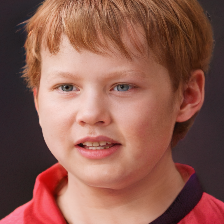

Image 0/100 | Current loss: 0.9065850973129272


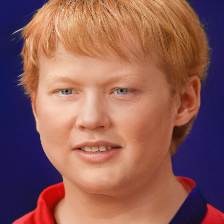

Image 10/100 | Current loss: 0.7659704685211182


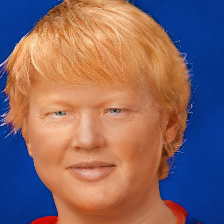

Image 20/100 | Current loss: 0.7765533328056335


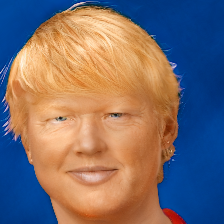

Image 30/100 | Current loss: 0.7598516941070557


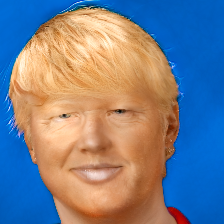

Image 40/100 | Current loss: 0.7399147748947144


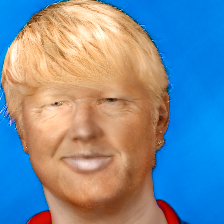

Image 50/100 | Current loss: 0.7362338900566101


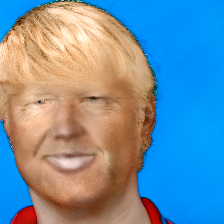

Image 60/100 | Current loss: 0.7341470718383789


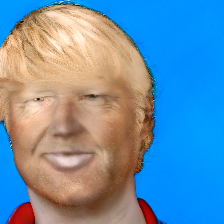

Image 70/100 | Current loss: 0.7274389266967773


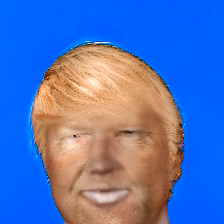

Image 80/100 | Current loss: 0.7730941772460938


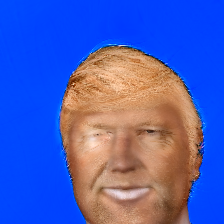

Image 90/100 | Current loss: 0.729733407497406


In [7]:
#@markdown #**Run the model** 🚀

# run model generation

tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
  ])

def run(timestring):
  torch.manual_seed(seed)

  # Init
  # Sample 32 inits and choose the one closest to prompt

  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(8):
      q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
      images = G.synthesis(q * w_stds + G.mapping.w_avg)
      embeds = embed_image(images.add(1).div(2))
      loss = prompts_dist_loss(embeds, targets, spherical_dist_loss).mean(0)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss[i])
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    # print(losses)
    # print(losses.shape, qs.shape)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).requires_grad_()

  # Sampling loop
  q_ema = q
  opt = torch.optim.AdamW([q], lr=0.03, betas=(0.0,0.999))
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis(w + G.mapping.w_avg, noise_mode='const')
    embed = embed_image(image.add(1).div(2))
    loss = prompts_dist_loss(embed, targets, spherical_dist_loss).mean()
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * 0.9 + q * 0.1
    image = G.synthesis(q_ema * w_stds + G.mapping.w_avg, noise_mode='const')

    if i % 10 == 0:
      display(TF.to_pil_image(tf(image)[0]))
      print(f"Image {i}/{steps} | Current loss: {loss}")
    pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    os.makedirs(f'samples/{timestring}', exist_ok=True)
    pil_image.save(f'samples/{timestring}/{i:04}.jpg')

try:
  timestring = time.strftime('%Y%m%d%H%M%S')
  run(timestring)
except KeyboardInterrupt:
  pass

In [8]:
#@markdown #**Save images** 📷
#@markdown A `.tar` file will be saved inside *samples* and automatically downloaded, unless you previously ran the Google Drive cell,
#@markdown in which case it'll be saved inside your previously created drive *samples* folder.

archive_name = "trumper"#@param {type:"string"}

archive_name = slugify(archive_name)

if archive_name != "optional":
  fname = archive_name
  # os.rename(f'samples/{timestring}', f'samples/{fname}')
else:
  fname = timestring
# Save images as a tar archive
!tar cf samples/{fname}.tar samples/{timestring}
if os.path.isdir('drive/MyDrive/samples'):
  shutil.copyfile(f'samples/{fname}.tar', f'drive/MyDrive/samples/{fname}.tar')
else:
  files.download(f'samples/{fname}.tar')

In [ ]:
#@markdown #**Generate video** 🎥

#@markdown You can edit frame rate and stuff by double-clicking this tab.

frames = os.listdir(f"samples/{timestring}")
frames = len(list(filter(lambda filename: filename.endswith(".jpg"), frames))) #Get number of jpg generated

init_frame = 1 #This is the frame where the video will start
last_frame = frames #You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.


#EDIT FRAME RATE HERE
min_fps = 10
max_fps = 60

total_frames = last_frame-init_frame

#Desired video time in seconds
video_length = 14 #@param {type:"number"}
#Video filename
video_name = "" #@param {type:"string"}
video_name = slugify(video_name)

if not video_name:
  video_name = "video"
# frames = []
# tqdm.write('Generating video...')
# for i in range(init_frame,last_frame): #
#     filename = f"samples/{timestring}/{i:04}.jpg"
#     frames.append(Image.open(filename))

fps = np.clip(total_frames/video_length,min_fps,max_fps)

print("Generating video...")
!ffmpeg -r {fps} -i samples/{timestring}/%04d.jpg -c:v libx264 -vf fps={fps} -pix_fmt yuv420p samples/{video_name}.mp4 -frames:v {total_frames}

# from subprocess import Popen, PIPE
# p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', f'samples/{video_name}.mp4'], stdin=PIPE)
# for im in tqdm(frames):
#     im.save(p.stdin, 'PNG')
# p.stdin.close()

print("The video is ready")

In [ ]:
#@markdown #**Download video** 📀
#@markdown If you're activated the download to GDrive option, the video will be saved there automatically. Don't worry about overwritting issues for colliding filenames, an id will be added to them to avoid this.

#@markdown If not, just copy the string you entered into the video_name field above, and paste it in the box below.

#Video filename
to_download_video_name = "" #@param {type:"string"}
to_download_video_name = slugify(to_download_video_name)

if not to_download_video_name:
  to_download_video_name = "video"


from google.colab import files
if os.path.isdir('drive/MyDrive/samples'):
  filelist = glob.glob(f'drive/MyDrive/samples/{to_download_video_name}*.mp4')
  video_count = len(filelist)
  if video_count:
    final_video_name = f"{to_download_video_name}{video_count}"
  else:
    final_video_name = to_download_video_name
  shutil.copyfile(f'samples/{video_name}.mp4', f'drive/MyDrive/samples/{final_video_name}.mp4')
else:
  files.download(f"samples/{to_download_video_name}.mp4")

In [ ]:
#@title Licensed under the MIT License { display-mode: "form" }

# Copyright (c) 2021 nshepperd; Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.